# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

**2023 update:** Changed to packages `gymnasium` and `renderlab`, and to `CartPole-v1`.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*.

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [ ]:
!pip install gymnasium
!pip install renderlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.4 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import renderlab as rl

First we create the environment:

In [ ]:
env = gym.make('CartPole-v1') # Create environment

A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [ ]:
s, _ = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [0.01886258 0.03158179 0.03305242 0.04118253]
sample action: 1


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [ ]:
env = gym.make("CartPole-v1", render_mode = "rgb_array") # Create environment
env = rl.RenderFrame(env, "./output") # To display environment in the notebook
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [ ]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Sequential(nn.Linear(n_inputs, n_hidden),
                                    nn.ELU(),
                                   nn.Linear(n_hidden, n_hidden),
                                   nn.ELU())
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [ ]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [ ]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [ ]:
# training settings

num_episodes = 400
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 50 # validation frequency

# setup policy network


policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training


  rollout = np.array(rollout)



  50. mean training reward:  24.26, mean validation reward:  28.90, mean loss:  8.7617
 100. mean training reward:  27.80, mean validation reward:  27.60, mean loss:  9.8737
 150. mean training reward:  21.90, mean validation reward:  13.60, mean loss:  7.6697
 200. mean training reward:  23.90, mean validation reward:  16.80, mean loss:  8.1980
 250. mean training reward:  30.38, mean validation reward:  29.20, mean loss: 10.2569
 300. mean training reward:  39.16, mean validation reward: 346.40, mean loss: 13.0027
 350. mean training reward:  88.24, mean validation reward: 268.70, mean loss: 27.3398
 400. mean training reward: 102.58, mean validation reward: 262.50, mean loss: 30.3424
done


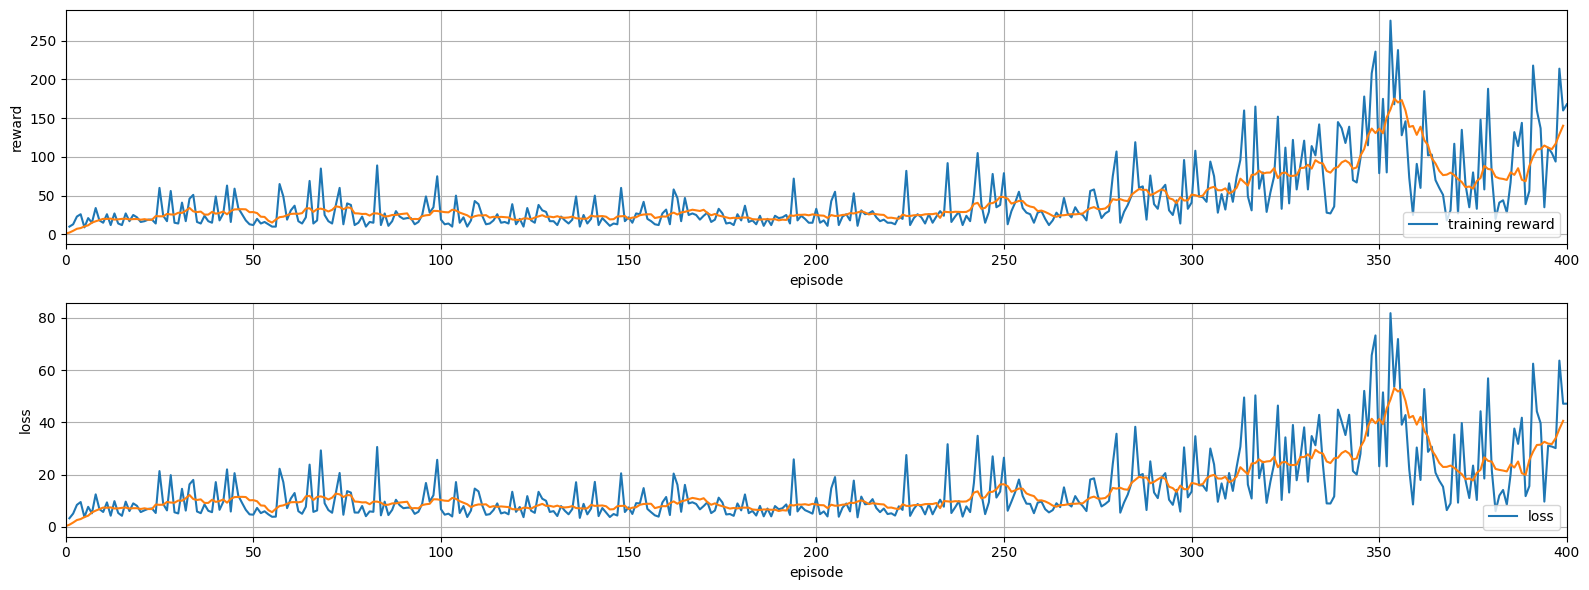

In [ ]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')

plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [ ]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**
To start to maintain balance for less time the number of episodes was reduced to 400. Then I played around with various variables for the discount factor but the original value of 1 seemed to do the trick best, since we need to consider long-term rewards to keep balance.

Then I played around with different rates from 0.000001 to 0.01 and found out that 0.001 had the best results.


At the end I also added a layer and switched from ReLU to ELU, so that the network fits better.

After all these changes the results seem to be consistent.

### Exercise 2

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

* The total reward is 5, and is the sum of the sequence.

* The future reward is calculated based on the cumulative sum of rewards from a time step in the sequence and onward. Therefore, the total future reward is [5, 5, 4, 3, 2, 2, 1, 0, 0, 0].

* The discounted future reward is calculated in the same way plus the multiplication with the gamma value. As a result the total discounted future reward [3.561, 3.957, 3.285, 2.539, 1.71, 1.9, 1, 0, 0, 0].


### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**
This happens because of the way the policy network is used during training and validation

In training we select randomly based on the policy network's output probabilities.

Whereas in validation we choose the action with the highest probability.

This leads to a trade of in exploration-exploitation, in training the agent will go through various actions, including the ones with low probability. This results in a lower validation reward. As we train the agant's policy becomes better. As a result during validation it explaits what it has learned more effectivly, leading us to a higher validation reward over time.


### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

The policy gradient method, as implemented here, addresses the exploration-exploitation dilemma by using the softmax action selection. As a result the policy network provides a probability distribution over available actions. This allows the agent to explore different actions with varying probabilities. Furthermore stochasticity enables the agent to try different actions even if they don't have the highest expected returns. This in turn encourages exploration. So in this case the exploration-exploitation dilemma is addressed by the softmax action selection that promotes a balance between exploration and exploitation.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate.

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

\\

### Exercise from the book

Suppose we have a neuron with 1000 inputs, where 500 are 1 and others are zero. We initialized weights as Gaussian random variables with mean 0 and variance $\frac{1}{1000}$. We chose bias as a Gaussian variable with mean 0 and standard daviation 1. Verify that the standard deviation of the weighted sum $z=\sum_j w_jx_j+b$ is $\sqrt{\frac{3}{2}}$.

**Answer:**

To find the standard deviation of the weighted sum, we apply basic properties of Gaussian distributions. When adding two independent Gaussian variables, we simply add their variances. In this case, we have 500 weights with a variance of 1/1000 each and a bias with a variance of 1. The total variance of the weighted sum $z$ is calculated as:

$$
V_z = \sum_j \frac{1}{1000} + 1
= 500 \times \frac{1}{1000} +
= \frac{3}{2}
$$

Therefore, the standard deviation of the weighted sum is the square root of the variance, which is $\sqrt{\frac{3}{2}}$.